# Introduction
In this document we will be constructing corpus of documents constructed by scraping abstracts from pubmed. A single corpus will be related to a single disease. We will use a BoW model for the corpus, and after preprocessing the text (stemming and all that) we will create a generative model of the corpus using Latent Dirichlet Allocation (LDA). Let's take a moment to discuss how LDA works.

# Overview of LDA
The first thing we need is a vocabulary, which is just a list of words that we use to generate documents. In real life, the only words you can use to write a document are the words in your personal vocabulary; so too with LDA. Next, we have a set of topics. Intuitively, a topic is something you write about, and your choice of topic determines what words you (are likely to) use. We formalize this intuition by defining a topic to be a probability distribution defined on the vocabulary. 

Now suppose we are going to write a document. Let there be $N$ topics in our model.  Let $w_i$ denote the $i-th$ word in the document, and let $\theta$ be a $N-$dimensional vector whose entries are all non-negative and sum to $1$ ($\sum_j \theta_j = 1$). We draw a random variable $z_i$, which follows the conditional distribution

\begin{equation}
z_i | \theta \sim Disc(\theta)
\end{equation}

where $Disc$ is the discrete distribution. The variable $z$ is a latent random variable indicating the topic from which we draw $w_i$. Let $\phi^{(z_i)}$ be another $N-$dimensional vector of non-negative real values whose entries sum to 1. Then, we choose $w_i$ by drawing from the following conditional distribution:

\begin{equation}
w_i | z_i, \phi^{(z_i)} \sim Disc(\phi^{(z_i)})
\end{equation}

This is done for each word in the document. An important point I completely ignored is where $\theta$ and $\phi$ come from. These will in general be different from document to document, and we capture this by treating them as random varibles drawn from the following distributions:

\begin{gather}
\phi \sim Dir(\alpha) \\
\theta \sim Dir(\beta)
\end{gather}

where $Dir$ is the Dirichlet distribution. This is where the name of the model comes from.

There are three hyperparameters in the model: $N, \alpha$, and $\beta$. At the time I am writing this I will not be discussing how one chooses $\alpha$ and $\beta$. As for $N$, we choose the number of topics by looking at the perplexity, something I hope to get more into later.

Something else I won't be discussing is how one trains an LDA model on a given corpus. Something that will be useful later on, however, are the fitted values of $\hat{\theta}$, which we will use to discover research trends.

# Discovering Research Trends
Something we will assume is that each document in our corpus has a known publication year. We will use the letter $T$ to denote the period (year) during which a given document was published. Now, for a fitted LDA model, let $\widehat{\theta}^{(d)}_{j T}$ denote the fitted topic weight for topic $j$ of document $d$. Construct the following functions of $T$:

\begin{equation}
f_{j}(T) = \frac{1}{N_T} \sum_{d_T = 1}^{N_T} \widehat{\theta}^{(d_T)}_{jT}
\end{equation}

where $d_T$ indexes the documents published during year $T$ and $N_T$ is the number of documents published during T.  $f_{j}(T)$ is the mean weight of topic $j$ for papers published during T. If topic $j$ is a hot topic, we expect that $f_{j}(T)$ will be increasing with increasing $T$, and if it's a cold topic, we expect $f_{j}(T)$ will be decreasing with increasing $T$. This gives us a simple graphical way of identifying research trends.



In [1]:
#Libraries
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import HdpModel

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd

import pyLDAvis.gensim as gensimvis
import pyLDAvis

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

Here we will read in some data and perform preprocessing on the data (tokenizing, lowercasing, stemming, removing stop words and punctuation, ...).

In [2]:
#Read in data and form pre-tokenzied documents
url = "pubmed_abstracts_batch2.csv"
data = pd.read_csv(url)
disease_data = data.loc[data.disease == "arthritis"]
documents = disease_data[['Date','abstract']]

#Need to make sure each abstract and date of documents is a string
documents = documents.loc[ [str(type(abstract))=="<class 'str'>" for abstract in documents.abstract] ]
documents = documents.loc[ [str(type(Date))=="<class 'str'>" for Date in documents.Date] ]
documents['Date'] = documents.Date.map(lambda x: float(x[0:4]) )

In [3]:
#Useful for later
stop_words = set(stopwords.words('english'))

wordnet_lemmatizer = WordNetLemmatizer()

def tokenize_document(document):
    tokens = [w for w in word_tokenize(document.lower()) if w.isalpha()]
    no_stops = [t for t in tokens if t not in stop_words]
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    return lemmatized

In [4]:
#Create tokenized documents
documents['tokenized_docs'] =  documents.abstract.map(tokenize_document)
tokenized_documents = list(documents['tokenized_docs'])

In [28]:
#Create gensim dictionary and create corpus
dictionary = Dictionary(tokenized_documents)
dictionary.filter_extremes(no_above=0.5)

documents['bow_doc'] = documents.tokenized_docs.map(dictionary.doc2bow)
corpus = documents['bow_doc'] 

# LDA Model
Now we create an LDA model. We won't fine tune the number of topics for now, just set it to something manually.

In [41]:
num_topics = 5
lda = LdaModel(corpus=corpus,id2word=dictionary, num_topics=num_topics, random_state=137)

In [42]:
topics = lda.show_topics()
for topic in topics:
    print(topic)

(0, '0.012*"joint" + 0.011*"ra" + 0.010*"pain" + 0.009*"disease" + 0.009*"associated" + 0.009*"p" + 0.008*"ci" + 0.007*"year" + 0.006*"factor" + 0.006*"inflammatory"')
(1, '0.012*"group" + 0.010*"ra" + 0.010*"disease" + 0.007*"joint" + 0.007*"p" + 0.007*"clinical" + 0.007*"effect" + 0.006*"treatment" + 0.005*"activity" + 0.005*"inflammatory"')
(2, '0.012*"disease" + 0.009*"health" + 0.009*"activity" + 0.009*"joint" + 0.008*"adult" + 0.008*"mouse" + 0.007*"pain" + 0.007*"inflammatory" + 0.007*"among" + 0.007*"year"')
(3, '0.012*"inflammatory" + 0.010*"joint" + 0.009*"group" + 0.009*"cell" + 0.008*"ra" + 0.007*"treatment" + 0.007*"health" + 0.007*"disease" + 0.007*"effect" + 0.006*"mouse"')
(4, '0.011*"disease" + 0.010*"inflammatory" + 0.009*"joint" + 0.008*"p" + 0.007*"activity" + 0.007*"year" + 0.006*"health" + 0.006*"group" + 0.006*"cell" + 0.006*"treatment"')


In [43]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

In [44]:
topic_weights = pd.DataFrame({'date' : documents.Date })

for topic_index in range(num_topics):
    topic_weights['topic_'+str(topic_index)] = documents['tokenized_docs'].map(lambda x: lda.get_document_topics(dictionary.doc2bow(x), minimum_probability=0.0)[topic_index][1])

In [48]:
mean_topic_weights = topic_weights.groupby(topic_weights.date).mean()

In [49]:
mean_topic_weights = mean_topic_weights.reset_index()

In [50]:
tidy_weights = pd.melt(mean_topic_weights, id_vars=['date'], value_vars=list(mean_topic_weights.columns.values)[1:])

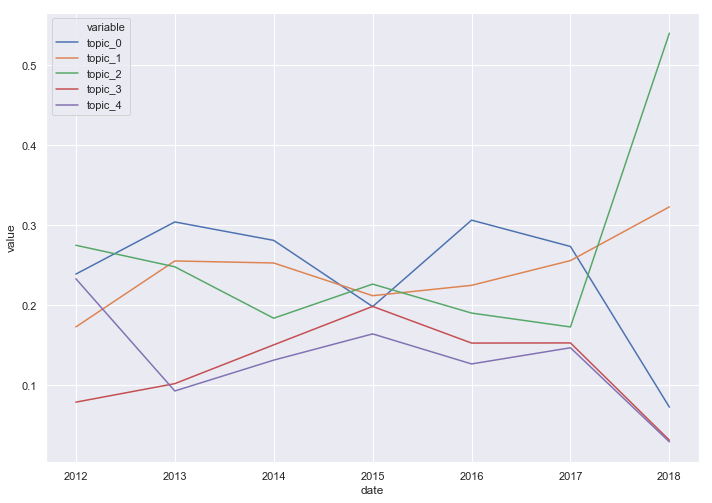

In [51]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="date", y="value", hue="variable", data=tidy_weights)

# Hierarchical Dirichlet Process Model